# Model selection and evidence in Bayesian statistics

### Written by: Alexandra Semposki

### Date started: 12 May 2021

This interactive notebook is meant to educate the reader in the basic theory of model selection and evidences, as well as how to determine which model is best, and to show three specific types of evidence determinaton. 

## Introduction: The theory of model selection and evidence

Model selection is the process of determining which of two or more possible models at hand fit the data set and prior information the best. We will focus on the case where we have two competing models, one with an extra parameter, and we would like to know which one is optimal, to show the basic theory. One way to measure this is to divide one model's posterior by the other as follows:

$$
\mathrm{posterior~ratio} = \frac{\mathrm{prob(A|D,I)}}{\mathrm{prob(B|D,I)}},
$$

where A stands for model A (__not__ just a parameter!) and B for model B.

Using Bayes' theorem, we get

$$
\frac{\mathrm{prob(A|D,I)}}{\mathrm{prob(B|D,I)}} = \frac{\mathrm{prob(D|A,I)}}{\mathrm{prob(D|B,I)}} \times \frac{\mathrm{prob(A|I)}}{\mathrm{prob(B|I)}}
$$

If we take the ratio of the priors (the right-most term), then we are left with the ratio of the 'likelihoods', which we will call the Bayes factor. In truth, these terms are the __evidence__ (or marginal likelihood) for their respective models. Depending on which one is larger, we can determine which model would be best for the data set at hand---whether we need that extra parameter or not. 

There are several ways to approach finding which model is suitable, and we will explore three of them here: the Laplace approximation (which can be handled analytically), thermodynamic integration and interpolation (purely numerical), and a different twist on this problem called the Savage-Dickey Density Ratio. 

## Data set and functions

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

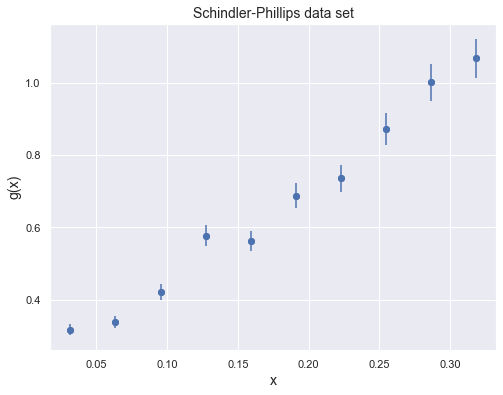

In [3]:
#import the Schindler-Phillips data set
x1 = 2.0/np.pi * np.array([0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5])
data1 = np.array([0.31694, 0.33844, 0.42142, 0.57709, 0.56218, 0.68851, 0.73625, 0.87280, 1.0015, 1.0684])
sig1 = np.array([0.01585, 0.01692, 0.02107, 0.02885, 0.02811, 0.03443, 0.03681, 0.04364, 0.0501, 0.0534])

#plot the data to check it
fig = plt.figure(figsize=(8,6))
plt.xlabel('x', fontsize = 14)
plt.ylabel('g(x)', fontsize = 14)
plt.title('Schindler-Phillips data set', fontsize = 14)
plt.plot(x1, data1, 'bo')
plt.errorbar(x1, data1, sig1, fmt='o')
plt.show()

Now we also need all of the functions as we defined in the section above. 

[Insert all of the functions here if we can do a universal setup.]

## Method 1: Analytical calculation of evidence using the Laplace approximation

Now we would like to be able to calculate the marginal likelihood, or evidence, for a given model. We will begin with a likelihood for our data that includes the chi-squared (Eq. (4.14), Sivia):

$$
\mathrm{prob(\{D_{k}\}|\{A_{j},x_{j}\},M,I)} \propto \exp \left(\frac{\chi^{2}}{2} \right). 
$$

From here we work out the details of the calculation until the Laplace approximation is finished in the attached PDF: [Laplace_approximation_details.pdf](Laplace_approximation_details.pdf).

This notebook will be primarily concerned with modelling the so-called Schindler-Phillips data set, a toy EFT model whose coefficients we'll be able to find and work with. This model is not the simplest of examples, but it is involved enough that it should be useful for those who have an intermediate problem to solve and are not well-suited with a simpler case. 

To begin the study, we first import the data set and all necessary packages for this method. 

In [1]:
#method 1 packages
import numdifftools as ndt
from scipy import optimize

In [18]:
#define a function for the model used in the likelihood
def g_model(a, x, k):

    g = 0.0
    
    for n in range(k+1):
        g += a[n] * (x**n)
        
    return g

#chi-squared of the data
def spresiduals(a, k, x=x1, data=data1, sig1=sig1):

    res = (data1 - g_model(a, x1, k))/sig1
    
    return res

#chi-squared summed over the polynomial degree
def spchisq(a, *args):
    
    k = args[0]
    
    abar = 5.0
    
    return np.sum((spresiduals(a, k))**2.0)

#augmented chi-squared
def spaugchisq(a, *args):

    k = args[0]
  
    abar = 5.0
    
    return np.sum((spresiduals(a, k))**2.0) + np.dot(a,a)/abar**2.0

#log likelihood 
def sp_log_likelihood(a, *args):
    
    return -0.5 * spchisq(a, *args)

#augmented log likelihood
def sp_aug_log_likelihood(a, *args):
    
    return -0.5 * spaugchisq(a, *args)

We will use a Gaussian prior with the likelihood from above, which is implemented as part of the Laplace approximation in the following code.

In [19]:
#set up the evidence calculation and a-bar (std dev of Gaussian prior)
degree_max = 8
evidence = np.zeros(degree_max+1)
abar = 5.0

#define chisqval
chisqval = np.empty(degree_max+1)

We need to loop over all of the chosen polynomial degrees, and in this for loop we will minimize the chi-squared from our Laplace approximation, use the package __numdifftools__ to calculate the Hessian matrix of the chi-squared, and compute the Laplace approximation in full. 

In [20]:
#begin printing the table here
print("Degree  P*          Best fit parameters: ")

#create the for loop 
for ideg,params in enumerate(range(degree_max+1)):
    
    #number of parameters for x0
    params = ideg + 1 
    
    #random guess array for minimization
    x0 = np.zeros(params)  
    
    #minimize the augmented chi-squared function
    result = optimize.minimize(spaugchisq, x0, args=(ideg), method='BFGS', tol=1e-8)
    
    #use numdifftools to generate the Hessian (scipy's calculation is unstable!)
    H = ndt.Hessian(spaugchisq)(result.x, ideg)

    #calculate the chi-squared values at the minima found
    chisqval[ideg] = spaugchisq(result.x, ideg)
    
    #calculate the exponentiated augmented chi-squared at the minimum
    P_star = np.exp(sp_aug_log_likelihood(result.x, ideg))

    #using Eq. (4.20) of Sivia 
    evidence[ideg] = (np.sqrt(2.0*np.pi)*abar)**(-(ideg+1)) * P_star \
                     * np.sqrt((4*np.pi)**(ideg + 1) / np.linalg.det(H))
  
    print (f'   {ideg}    {P_star:.2e}  ',('{:5.2f} '*len(result.x)).format(*result.x))

print('\nChi-squared at the minima:', chisqval)

Degree  P*          Best fit parameters: 
   0    8.31e-131    0.48 
   1    1.15e-04    0.20  2.55 
   2    2.47e-03    0.25  1.63  3.14 
   3    2.48e-03    0.25  1.65  2.98  0.37 
   4    2.48e-03    0.25  1.65  2.98  0.38 -0.02 
   5    2.48e-03    0.25  1.65  2.98  0.38 -0.02 -0.03 
   6    2.48e-03    0.25  1.65  2.98  0.38 -0.02 -0.03 -0.02 
   7    2.48e-03    0.25  1.65  2.98  0.38 -0.02 -0.03 -0.02 -0.01 
   8    2.48e-03    0.25  1.65  2.98  0.38 -0.02 -0.03 -0.02 -0.01 -0.00 

Chi-squared at the minima: [599.0416998   18.13840113  12.00611056  11.99885811  11.99883354
  11.9987894   11.99877822  11.99877602  11.99877563]


The best fit parameters above can be checked against Table III in Wesolowski et al. (https://arxiv.org/pdf/1511.03618.pdf). Now let's see what the plot looks like.

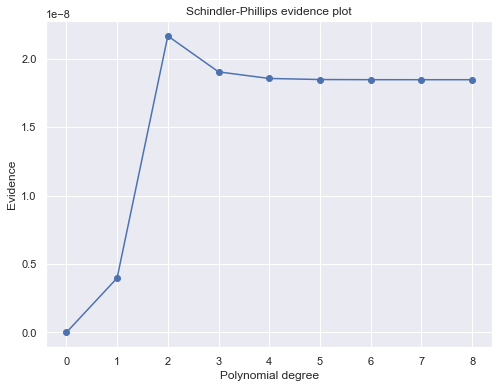

In [21]:
#plot
d = np.arange(0, degree_max+1)

fig,ax = plt.subplots(figsize=(8, 6))
ax.plot(d,evidence,'o-')

ax.set_xlabel('Polynomial degree')
ax.set_ylabel('Evidence')
ax.set_title('Schindler-Phillips evidence plot')
plt.show()

From this plot, we can see that the evidence is highest for the degree d = 2. This plot correctly matches that of the paper by Wesolowski et al., where the Schindler-Phillips data was used to generate Fig. 8. The shape of this plot is the same as that of the paper, but the scale is __not__. Why? This is because we have dropped the normalization constant on the likelihood function. Had we included it in the same way as Wesolowski et al., we should see the same scale as they do. However, for our purposes, it is okay if we do not scale by the normalization and leave the above as is.

This concludes the first method to finding the evidence. In the next section we will try to reproduce the evidence plot above using parallel tempering, a variation on MCMC sampling. 

## Method 2: Investigating model evidence via parallel tempering and Gaussian quadrature

As we are about to see, what can be done analytically can usually be done numerically, so now we turn to a completely numerical method of calculating the best-fit parameters and the evidence for each of the polynomial degrees. We will be employing the method of parallel tempering, or thermodynamic integration. The package __ptemcee__ has been designed for this purpose, but, as of the time this notebook was written, no comprehensive documentation exists publicly for this package. Here we will explore the basics of __ptemcee__ and how to use it to calculate coefficients of a polynomial, similarly to what we will later do with a typical MCMC sampler.

The package has already been imported, so we will start by setting up the required functions for the sampler. In the functions previously written, we could easily send the degree of the polynomial in, but now to run them with ptemcee we'd need a global variable for that. In order to use this section of the notebook, each polynomial degree must be run separately, so we'll declare the global variable later on and re-write the functions above with this change implemented. 

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

import ptemcee
import optemcee
import corner
from scipy import interpolate
from scipy.integrate import quadrature

In [9]:
#model function
def g_model(a, x=x1):

    g = 0.0
    
    for n in range(k+1):
        g += a[n] * (x**n)
        
    return g

#log likelihood function
def log_likelihood(a, x=x1, data=data1, sig=sig1, nd=10):
        
    #calculate the chi-squared
    chisq = 0.0 
    
    for i in range(nd):
        chisq += ((data[i] - g_model(a, x[i]))/sig[i])**2.0
                
    #finish the function
    f = -0.5 * (np.sum(np.log(2.0 * np.pi * sig**2.0)) + chisq)
        
    return f

#gaussian prior
def log_gaussprior(a):
    afix = 5.0
    pre = -(k + 1) * np.log(np.sqrt(2.0 * np.pi)*afix)
    return pre - np.dot(a,a)/(2.0*afix**2.0)

#log posterior
def log_posterior(a, x=x1, data=data1, sig=sig1, nd=10):
    return log_gaussprior(a) + log_likelihood(a, x, data, sig, nd)

Now we write some other functions that will be useful later when we want to plot our results from the sampler.

In [20]:
#useful sampling functions to call later on
def compute_sigma_level(trace1, trace2, nbins=20):
    """From a set of traces, bin by number of standard deviations"""
    L, xbins, ybins = np.histogram2d(trace1, trace2, nbins)
    L[L == 0] = 1E-16
    logL = np.log(L)

    shape = L.shape
    L = L.ravel()

    # obtain the indices to sort and unsort the flattened array
    i_sort = np.argsort(L)[::-1]
    i_unsort = np.argsort(i_sort)

    L_cumsum = L[i_sort].cumsum()
    L_cumsum /= L_cumsum[-1]
    
    xbins = 0.5 * (xbins[1:] + xbins[:-1])
    ybins = 0.5 * (ybins[1:] + ybins[:-1])

    return xbins, ybins, L_cumsum[i_unsort].reshape(shape)

#plot the trace from the sampler
def plot_MCMC_trace(ax, xdata, ydata, trace, scatter=False, **kwargs):
    """Plot traces and contours"""
    xbins, ybins, sigma = compute_sigma_level(trace[0], trace[1])
    ax.contour(xbins, ybins, sigma.T, levels=[0.683, 0.955, 0.997], **kwargs)
    if scatter:
        ax.plot(trace[0], trace[1], ',k', alpha=0.1)
        ax.set_title(r'Parameters $a_{0}$ and $a_{1}$')
        ax.set_xlabel(r'$a_{0}$')
        ax.set_ylabel(r'$a_{1}$')
    
# Convenience function to extract the peak position of the mode
def max_of_mode(sampler_object):
    max_arg = np.argmax(sampler_object.flatlnprobability)
    return(sampler_object.flatchain[max_arg])

Let's check the version of the sampler that we are using here.

In [24]:
#version of the sampler
print('ptemcee sampling (version: {})'.format(ptemcee.__version__))

ptemcee sampling (version: 1.0.0)


Let's set up the necessary variables for the parallel tempering sampler.

In [25]:
#number of dimensions
ndim = 4

#walkers
nwalkers = 50 

#burn-in
nburnin = 1000

#iterations
niterations = 4250

Now we need to set up an array of beta values to send to the sampler. These are inverted temperatures: $\beta = 1/\mathrm{T}$. We need this array of betas to be in descending order (from highest value to lowest value) in order for the sampler to give us back results in the correct order of temperature (which will therefore be in ascending order). The reason for this becomes apparent when we plot results according to which rung of the temperature 'ladder' we are on. 

In [26]:
#betas
ntemps_lo = 16
ntemps_hi = 7
temps_lo = np.array([1e-9, 1e-8, 5e-7, 1e-7,1e-6, 2.26e-6, 6.14e-6, 0.00001, 0.00005, 0.00003, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05])
temps_hi = np.array([1.0/np.sqrt(2)**i for i in range(ntemps_hi)])

original_betas = np.concatenate((temps_lo,temps_hi[temps_hi>max(temps_lo)]))

#invert the betas so that they are in descending order
betas = np.sort(original_betas)[::-1]

print('Individual temps: ')
print('\nLow: ', temps_lo)
print('\nHigh: ', temps_hi)

#print the inverted beta array
print("\nArray of betas:\n", betas)

#temperatures (these should appear in ascending order)
temps = 1/betas
print("\nArray of temperatures:\n", temps)

#number of temperatures
ntemps = len(temps)
print("\nNumber of temperatures: ", ntemps)

Individual temps: 

Low:  [1.00e-09 1.00e-08 5.00e-07 1.00e-07 1.00e-06 2.26e-06 6.14e-06 1.00e-05
 5.00e-05 3.00e-05 1.00e-04 5.00e-04 1.00e-03 5.00e-03 1.00e-02 5.00e-02]

High:  [1.         0.70710678 0.5        0.35355339 0.25       0.1767767
 0.125     ]

Array of betas:
 [1.00000000e+00 7.07106781e-01 5.00000000e-01 3.53553391e-01
 2.50000000e-01 1.76776695e-01 1.25000000e-01 5.00000000e-02
 1.00000000e-02 5.00000000e-03 1.00000000e-03 5.00000000e-04
 1.00000000e-04 5.00000000e-05 3.00000000e-05 1.00000000e-05
 6.14000000e-06 2.26000000e-06 1.00000000e-06 5.00000000e-07
 1.00000000e-07 1.00000000e-08 1.00000000e-09]

Array of temperatures:
 [1.00000000e+00 1.41421356e+00 2.00000000e+00 2.82842712e+00
 4.00000000e+00 5.65685425e+00 8.00000000e+00 2.00000000e+01
 1.00000000e+02 2.00000000e+02 1.00000000e+03 2.00000000e+03
 1.00000000e+04 2.00000000e+04 3.33333333e+04 1.00000000e+05
 1.62866450e+05 4.42477876e+05 1.00000000e+06 2.00000000e+06
 1.00000000e+07 1.00000000e+08 1.0000000

We also want to determine where in these chains is $\beta = 1$, as we want to specifically look at this case when we plot our coefficients. We can do this below.

In [27]:
#find the slot where beta = 1.0 (for displaying results later)
index = np.where(betas== 1.)
location = index[0]
one = location[0]
print('Location of beta = 1.0:', one)

Location of beta = 1.0: 0


The last thing to do before getting the sampler initialized is to declare the global variable for the polynomial degree. This will be done using the value of the dimension of the sampler so that we only have to change one variable every time we run this code. 

In [28]:
#order of the polynomial --- global variable
k = ndim-1

#print k 
print('k = {}'.format(k))

k = 3


Now we initialize the position array for each of the walkers the sampler will use, and print the number of samples per walker. 

In [29]:
#print the number of walkers and steps out
print('Using {} walkers with {} steps each.'.format(nwalkers, niterations))

#initialize the position
p0 = np.random.normal(size=(ntemps, nwalkers, ndim))

Using 50 walkers with 4250 steps each.


We run the sampler below. It uses a function from __optemcee__, a script written by Daniel Odell, that returns a 'chain' object we are calling result1 and result2 below. The components of this object are the samples, log likelihood, and log prior calculated at each step.

In [30]:
#run the ptemcee routine
sampler = ptemcee.Sampler(nwalkers, ndim, log_likelihood, log_gaussprior, betas=betas)

#burn-in
print("Running burn-in phase")
result1 = optemcee.run_mcmc(sampler, p0, nburnin, thin=None)
print('Run complete!')
          
#extract the final position from the burn-in and give to the sampler
chain0 = result1[0]

#pull the last position
pf = chain0[nburnin-1, :, :, :]

#sampling
print("Running MCMC chains")
result2 = optemcee.run_mcmc(sampler, pf, niterations, thin=None)
print('Calculation complete!')

  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Running burn-in phase


  0%|                                                                                 | 1/4250 [00:00<13:14,  5.35it/s]

Run complete!
Running MCMC chains


100%|██████████████████████████████████████████████████████████████████████████████| 4250/4250 [08:12<00:00,  8.63it/s]

Calculation complete!


After the run is complete, we need to extract the chain of samples from the object as an array so that we can manipulate it using attributes of numpy and other packages. 

In [31]:
#now we extract the actual chain from the overall results, to get the sampling positions
chain = result2[0]

#chain has shape (nsteps, ntemps, nwalkers, ndim)
print(type(chain))

#examine the shape of the array so we know what we're dealing with
print(chain.shape)

<class 'numpy.ndarray'>
(4250, 23, 50, 4)


Let's extract the $\beta = 1$ chain. This corresponds to T = 1, which is the closest we can get to T = 0 with our chosen $\beta$ and T values.

In [32]:
#obtain the T = 1 mean
mu0 = np.mean(np.mean(chain[:,one,:,:], axis=0), axis=0)
print("The T = 1 mean is: {}".format(mu0))

The T = 1 mean is: [0.24723522 1.64563555 2.9769985  0.38231447]


We reshape the chain and plot the T = 1 coefficient results.

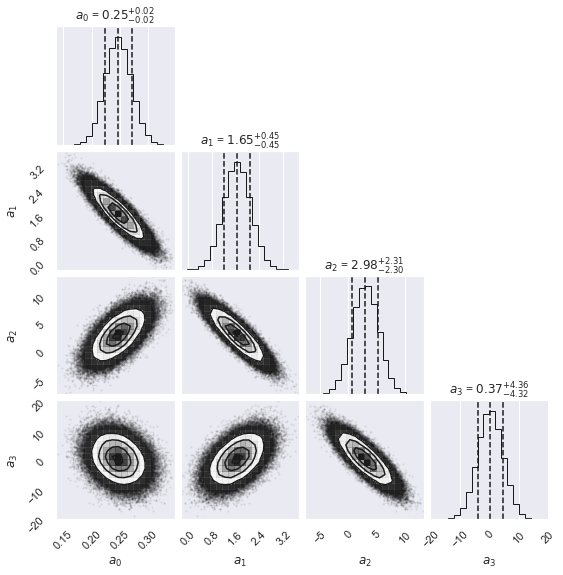

In [33]:
#reshape the chain
mcmc_data0 = chain[:,one,:,:].reshape(-1,ndim).T

#plot the results
fig, ax = plt.subplots(ndim,ndim, figsize=(8,8))
corner.corner(mcmc_data0.T,labels=[r"$a_{0}$", r"$a_{1}$", r"$a_{2}$", r"$a_{3}$", r"$a_{4}$", "r$a_{5}$", r"$a_{6}$"], \
              quantiles=[0.16, 0.5, 0.84], fig=fig, show_titles=True);

#extract the axes
axes = np.array(fig.axes).reshape((ndim, ndim))

The above plot is with respect to all of the betas and all of the samples we obtained in our routine. However, we would like to see the separate chains of betas on individual plots, so we implement this below. 

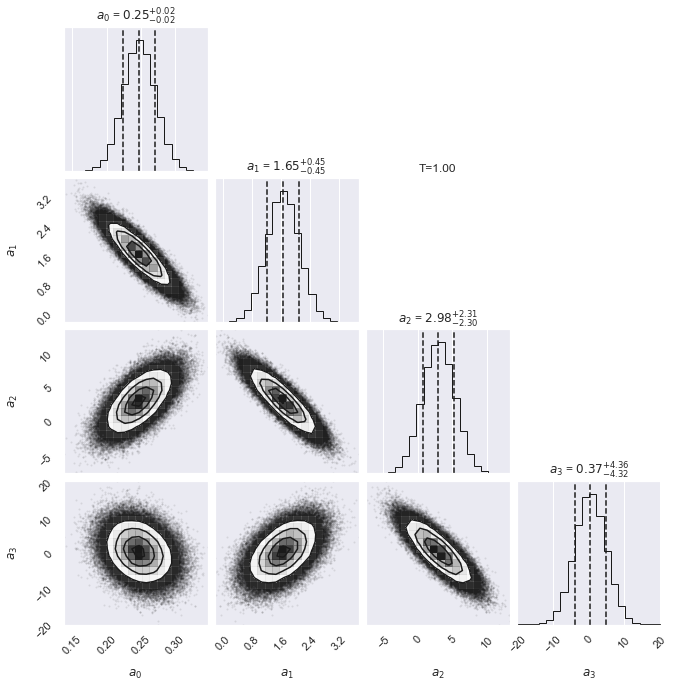

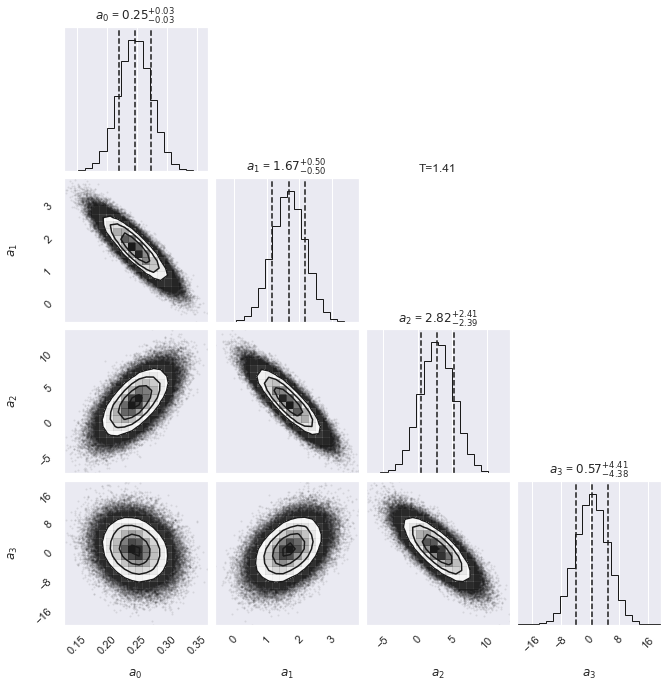

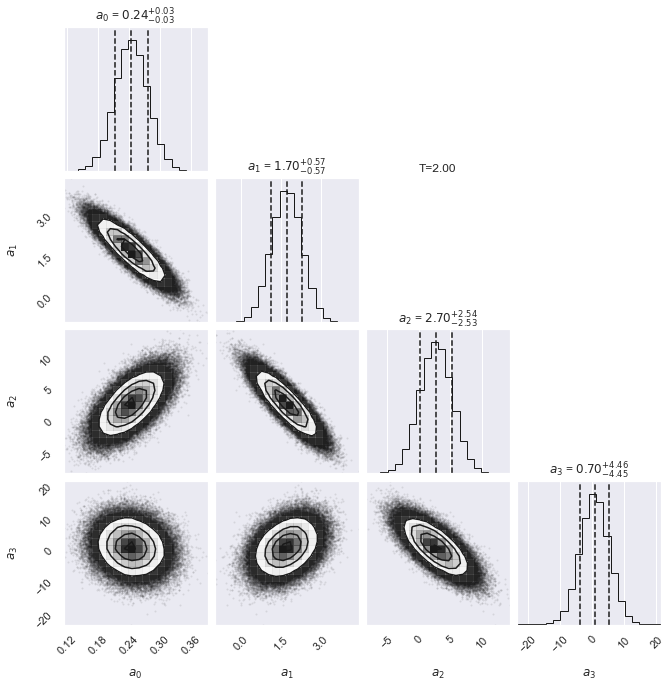

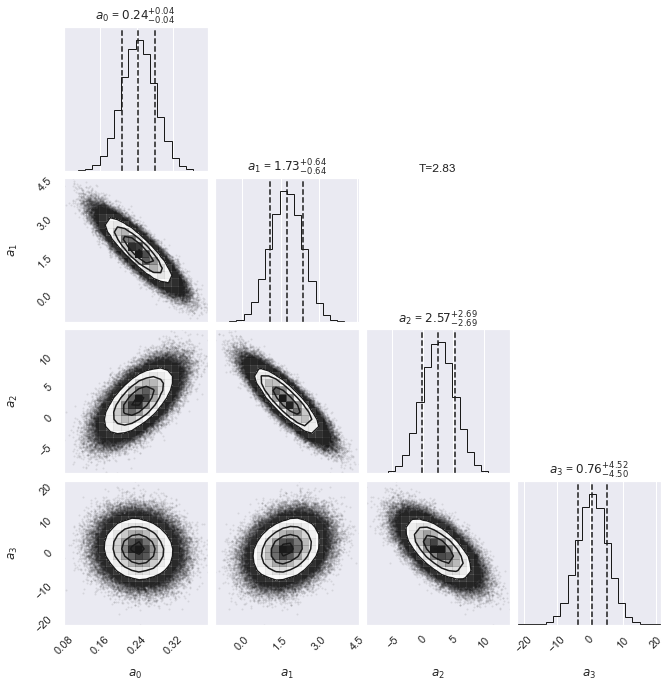

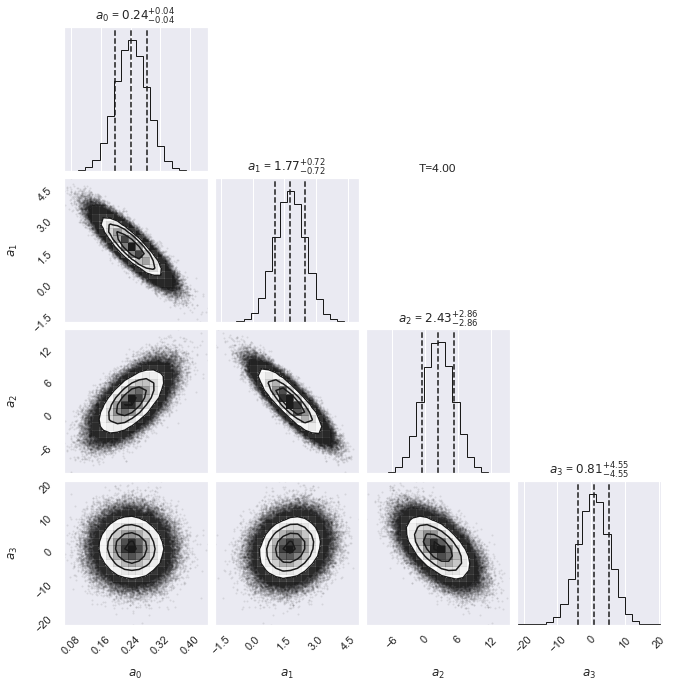

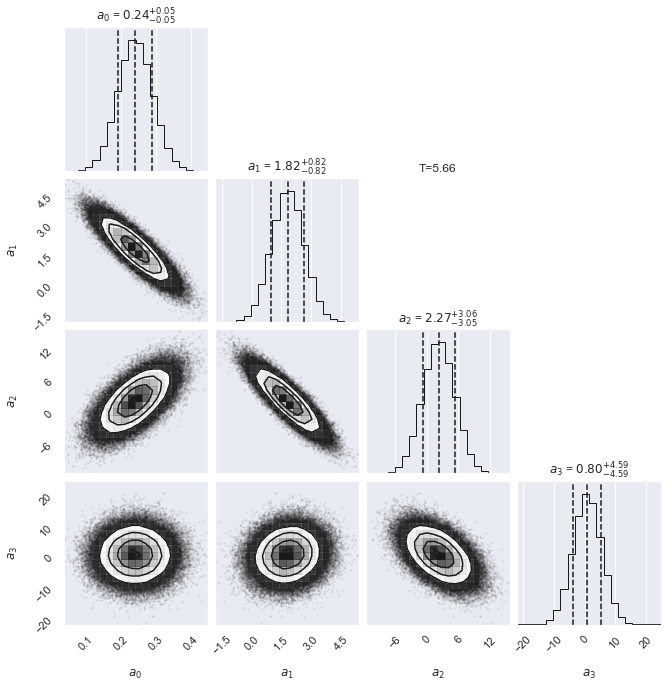

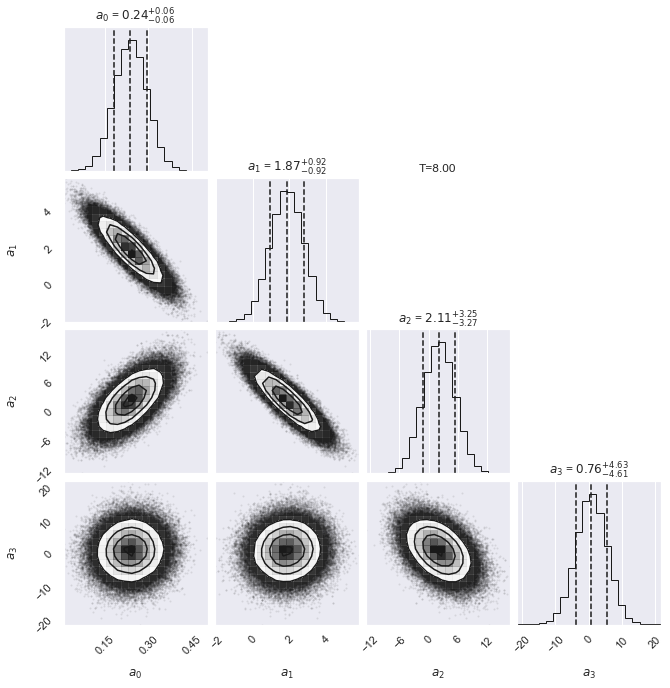

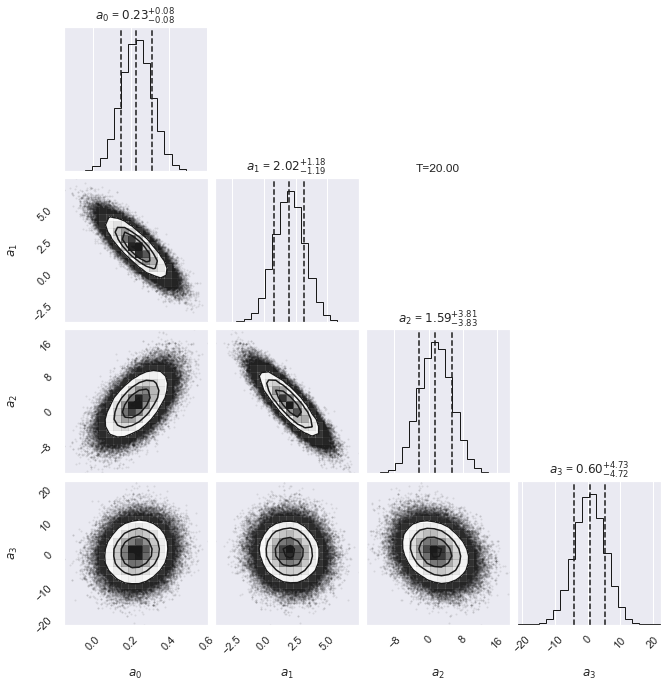

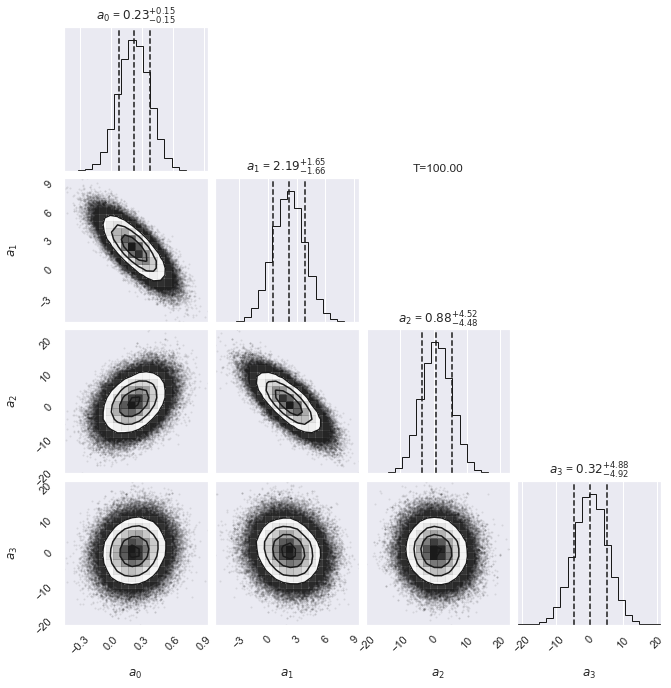

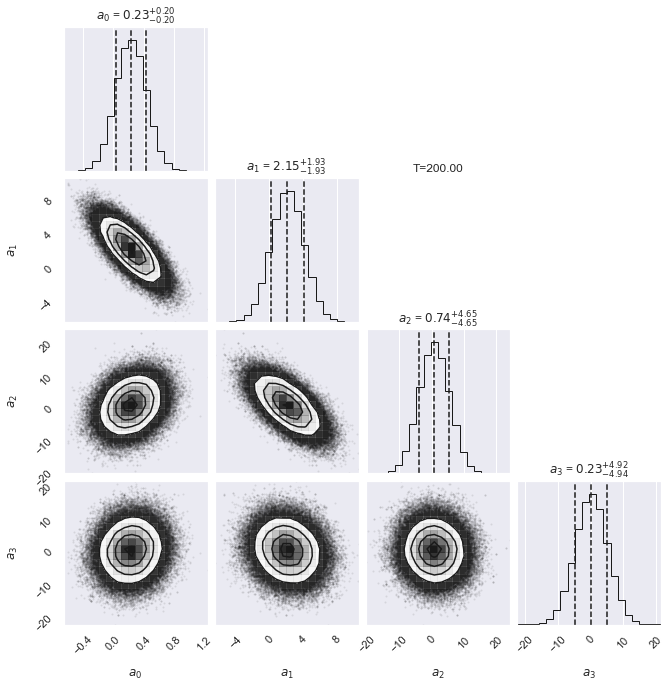

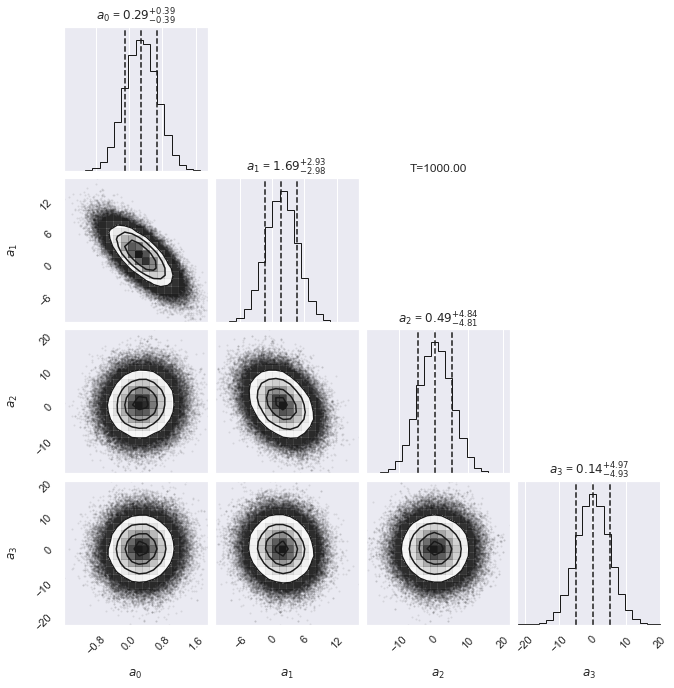

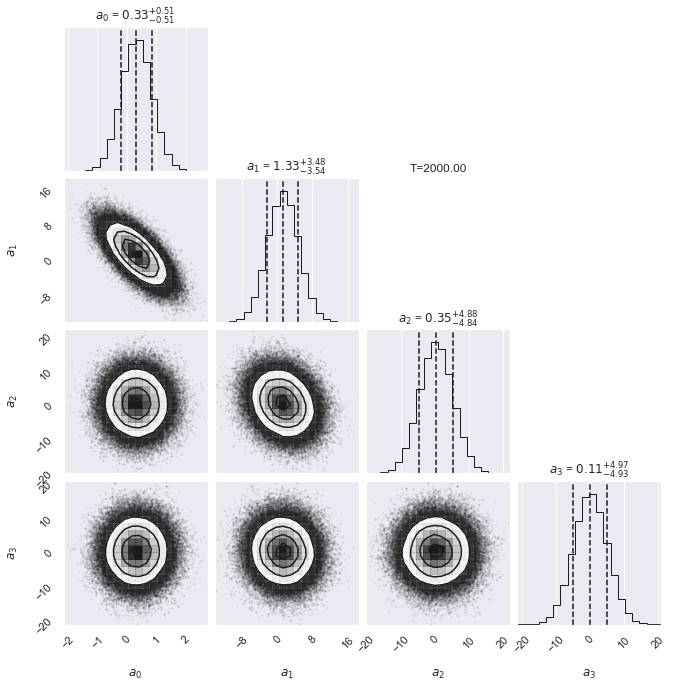

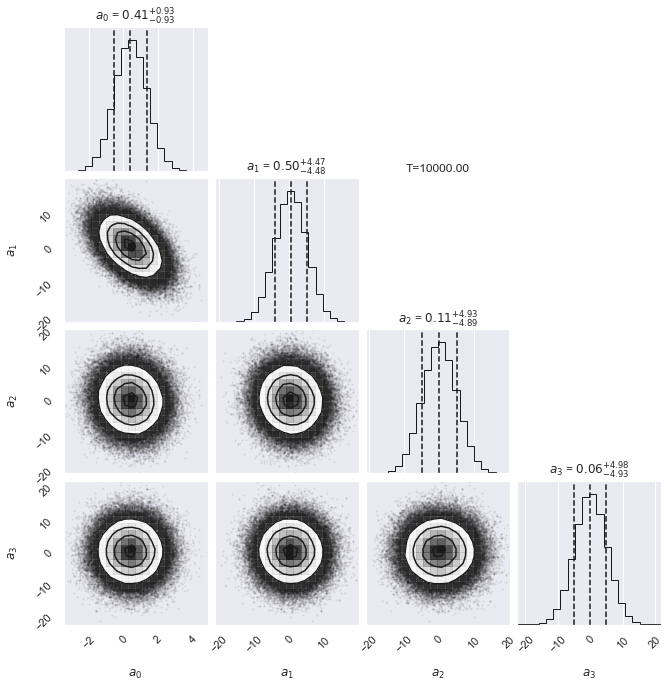

In [34]:
#extract each of the betas (beta[0], beta[1], etc.)
ntempered = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])

#write a for loop to plot the different results
for nt in ntempered:
    mcmc_data_nt = chain[:, nt, :, :].reshape(-1,ndim)
    figure = corner.corner(mcmc_data_nt, labels = [r"$a_{0}$", r"$a_{1}$", r"$a_{2}$", r"$a_{3}$", r"$a_{4}$", "r$a_{5}$", r"$a_{6}$"], \
                           quantiles=[0.16, 0.5, 0.84], show_titles=True);
    
    # Extract the axes
    axes = np.array(figure.axes).reshape((ndim, ndim))
    axes[ndim-3, ndim-2].set_title('T=%.2f' %temps[nt])

Once we have the coefficients as accurate as we can achieve (to do this, we might need to change the number of samples, number of walkers, or number of temperature rungs), we want to look at the likelihood results in the second part of the chain object that was returned by the sampler. To do this, we extract the array from result2. The likelihood results are needed to calculate the evidence, or marginal likelihood, for each polynomial degree. These are used to compute the expectation value of the log likelihood so we can then integrate and obtain the log of the evidence. The equation for the expectation value is given below (Eq. (12.19) from P. Gregory's *Bayesian Logical Data Analysis for the Physical Sciences with Mathematica Support*):

$$
\langle \ln{[p(D|M_{1},X,I)]} \rangle_{\beta} = \frac{1}{n} \sum_{t} \ln{[p(D|M_{1},X_{t,\beta},I)]}.
$$

Above, n refers to the total samples for the specific temperature $\beta$, and t refers to the sum over walkers, samples, and temperatures. 

In [35]:
loglresults = result2[1]

#print the classifications of this object
print('*** Classifications: loglresults ***')
print('Type: ', type(loglresults))
print('Shape: ', loglresults.shape)

*** Classifications: loglresults ***
Type:  <class 'numpy.ndarray'>
Shape:  (4250, 23, 50)


In order to use the log likelihood results, we need to integrate the equation for the log of the evidence (Eq. (12.24) of P. Gregory's *Bayesian Logical Data Analysis for the Physical Sciences with Mathematica Support*):

$$
\ln{[p(D|M_{1}, I)]} = \int{d\beta \langle \ln{[p(D|M_{1},X,I)]} \rangle_{\beta}}.
$$
To do this in a stable manner, we can use the __interpolate__ option in scipy to get a model for the general log likelihood curve. Then we can space our points in any way we wish to to compute the integral. For Gaussian quadrature, we only need to employ the __quadrature__ option from __scipy.integrate__. This method is much more accurate than Simpson's Rule, at least in the case of the Schindler-Phillips work done here. 

We must also remember to exponentiate the finals results before making our evidence plot, in order to obtain the evidence and not the log of the evidence!

In [49]:
#define the samples of each beta value
nwalkers = 50
niterations = 4250
nsamples = nwalkers * niterations

#expectation value array
expect_value = np.zeros(ntemps)
expect = np.zeros(ntemps)
count = np.zeros(ntemps, dtype='int')
evidence = 0.0

#sum over samples and walkers for each beta
for b in range(ntemps):
    for i in range(niterations):
        for j in range(nwalkers):
            expect_value[b] = expect_value[b] + loglresults[i,b,j]
            
            count[b] = count[b] + 1

    #for each beta get expectation value
    expect[b] = (count[b])**(-1.0) * expect_value[b]  
    
#print the expectation values for each beta
print('Expectation values: \n', expect)
print('Number of samples: ', nsamples)

#define the interpolated function
f = interpolate.interp1d(betas, expect, kind='linear', fill_value='extrapolate')

#employ Gaussian quadrature for the integral
evidence_gauss = quadrature(f, 0.0, 1.0)
#print the results of the integration
print('\nEvidence for the k = {} polynomial: {} '.format(k, evidence_gauss[0]))
print('\nCounts per walker: ', count)

Expectation values: 
 [ 1.84703764e+01  1.78702478e+01  1.70174892e+01  1.58526769e+01
  1.42480650e+01  1.20395575e+01  9.04969574e+00 -5.11521605e+00
 -8.71873895e+01 -1.84184656e+02 -8.68192906e+02 -1.60105411e+03
 -6.03830143e+03 -1.07903155e+04 -1.66798333e+04 -4.11573519e+04
 -5.87065674e+04 -1.05076847e+05 -1.42091867e+05 -1.64217652e+05
 -1.88403751e+05 -1.94897901e+05 -1.95486527e+05]
Number of samples:  212500

Evidence for the k = 3 polynomial: 8.001569583829255 

Counts per walker:  [212500 212500 212500 212500 212500 212500 212500 212500 212500 212500
 212500 212500 212500 212500 212500 212500 212500 212500 212500 212500
 212500 212500 212500]


The warning above can be ignored for us because we are not going to get a level of precision more than a couple of decimal places. 

Below we plot the log likelihood (really the interpolation function, at many more points than beta possesses to see how it behaves) over the beta points we have chosen. 

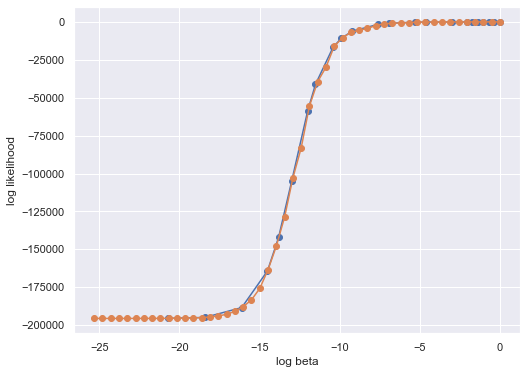

In [43]:
#log beta
log_betas = np.log(betas)

#new array of points for interpolation function (to check)
nptslow = 16
nptshigh = 6
xpoints = np.linspace(-11,0,50)
pts_lo = np.array([10**i for i in xpoints])
pts_hi = np.array([1.0/np.sqrt(2)**i for i in range(nptshigh)])
original_pts = np.concatenate((pts_lo,pts_hi[pts_hi>max(pts_lo)]))
pts = np.sort(original_pts)[::-1]
log_pts = np.log(pts)

#plot the log likelihood vs log beta
fig,ax1 = plt.subplots(figsize=(8, 6))
ax1.plot(log_betas, expect,'o-')
ax1.plot(log_pts, f(pts), 'o-')
ax1.set_xlabel('log beta')
ax1.set_ylabel('log likelihood');
plt.show()

This appears accurate enough to say that we have achieved an interpolation function that yields, using Gaussian quadrature, a good estimate of the evidence per "model" (polynomial degree). 

By changing the code above for each degree of the polynomial (this can be done by changing ndim to an integer anywhere between 1 and 9, while noting that the degree k will be one integer less than the dimension chosen) we can create an evidence plot like the one we had in the analytical method. Below is a finished version, which looks close to the analytical solution, though not quite a perfect match.

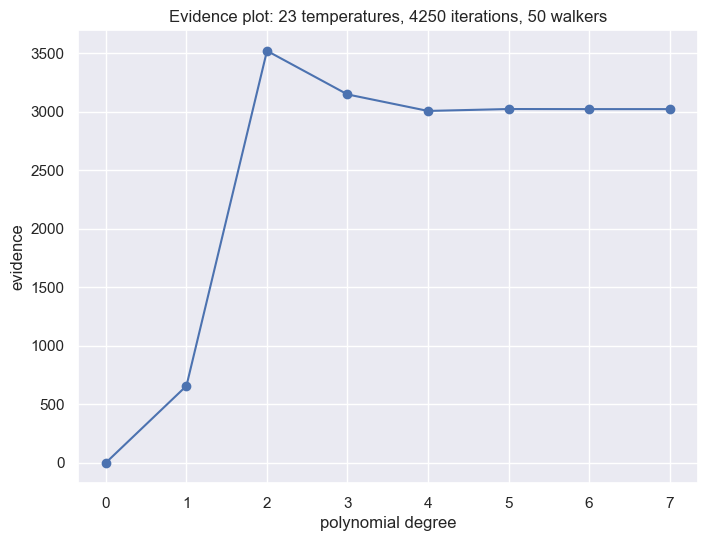

Evidence ratios: 
k = 0: evidence ratio = 0.0
k = 1: evidence ratio = 4.790261486421694
k = 2: evidence ratio = 0.8941944695530767
k = 3: evidence ratio = 1.0
k = 4: evidence ratio = 1.0469110800889656
k = 5: evidence ratio = 1.0412979876337616
k = 6: evidence ratio = 1.0415625109156552
k = 7: evidence ratio = 1.0415583446739454


In [47]:
#evidence plot -> Gaussian quadrature
d = np.arange(0, 8)

gauss_results1 = np.array([0.0, 6.488178, 8.166595, 8.054763, 8.008919, 8.014295, 8.014041, 8.014045])

#exponentiate the results to get the evidence (instead of the log of the evidence)
gauss_results = np.exp(gauss_results1)

fig,ax = plt.subplots(figsize=(8, 6), dpi = 100)
ax.plot(d,gauss_results,'o-')

ax.set_title('Evidence plot: 23 temperatures, 4250 iterations, 50 walkers')
ax.set_xlabel('polynomial degree')
ax.set_ylabel('evidence');
plt.show()

#ratio table
degree_max = 8
ratio = np.empty(degree_max)

for i in range(degree_max):
    if i == 0:
        ratio[i] = 0.0
    else:
        ratio[i] = gauss_results[3] / gauss_results[i]

print('Evidence ratios: ')

for i in range(degree_max):
    print('k = {}: evidence ratio = {}'.format(i, ratio[i]))

The table above contains the ratio between the evidence for k = 3 and all of the other degrees, except k = 0, which has been set to 0.0 because the evidence for this value was so small that anything higher makes the ratio go quickly to $\infty$. The evidence for k = 0 in the plot above has also been set to zero due to how small it is. 

In the next section, we will look at the final method for determining evidence: the Savage-Dickey density ratio, which is not a model for evidence in the same way as the last two methods have been, but rather a method to be used when two models are in competition and one must be chosen as the best way forward. 

## Method 3: MCMC Sampling and the Savage-Dickey Density Ratio

Now we can move to the last method here, where we'll calculate the coefficients using the simple MCMC package __emcee__, which employs the Metropolis-Hastings routine. Then we can use the results to calculate the Savage-Dickey Density Ratio, which we outline here. 


The Savage-Dickey Density Ratio, or SDDR, is a ratio between two models, for example, one with two free parameters and one with only one free parameter. The ratio's derivation can be found in the document here (following Trotta's Appendix B, [Appendix_B_derivation.pdf](Appendix_B_derivation.pdf)), but we'll just show the final result below (Eq.(7) from Roberto Trotta's paper *Applications of Bayesian model selection to cosmological parameters*): 

$$
B_{01} = \frac{p(\omega|d, M_{1})}{p(\omega|M_{1})} \bigg{|}_{\omega = \omega*},
$$

where $M_{1}$ is the model possessing an extra free parameter ($M_{0}$ is the other), $d$ is the data, and $\omega$ is the single free parameter shared by the two models (fixed here for comparison). The numerator pdf is the posterior of model $M_{1}$, and the denominator pdf is the prior of model $M_{1}$, so calculating the SDDR only involves results from the second model, making this a computationally simple expression to evaluate.

First we will import emcee and use it to find the posterior and prior we need. 

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

import emcee
import corner

In [26]:
#re-define constants for this specific routine
ndim = 4
nwalkers = 50 
nsteps = 20000 

total_samples = nwalkers * nsteps

print('The total number of samples will be {}.'.format(total_samples))

#number of data points
nd = 10 

#order of the polynomial
k = ndim - 1

#dummy number to indicate real value
kreal = 3

print('Using {} walkers with {} steps each.'.format(nwalkers, nsteps))

#initialize the sequence by starting the walkers at a random point
starting_points = np.random.randn(nwalkers, ndim)

The total number of samples will be 1000000.
Using 50 walkers with 20000 steps each.


### Sampling the posterior

In this step, everything we did for the parallel tempering results (printing corner plots, slicing arrays of data) applies. It's easier to do this method, however, because we are not dealing with thermodynamic integration.

In [28]:
#run the sampler over the Gaussian posterior
sampler_post = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[x1, data1, sig1, nd])

#run the sampler and print the wall time
%time sampler_post.run_mcmc(starting_points, nsteps)
print('Calculation finished!')

Wall time: 1min 25s
Calculation finished!


Max posterior is at: [0.248 1.632 3.017 0.388]


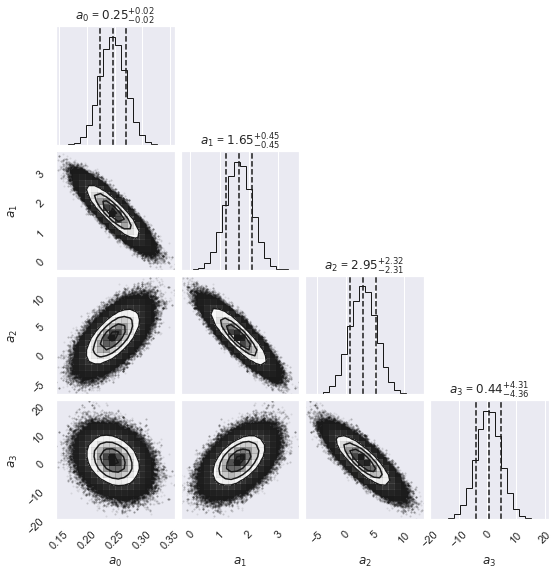

In [31]:
#reshape and cut burn-in
emcee_trace_post = sampler_post.chain[:, :, :].reshape(-1, ndim).T

#burn-in
nburnin = 1000

#throw out the burn-in and reshape again
emcee_trace_post = sampler_post.chain[:, nburnin:, :].reshape(-1, ndim).T
emcee_lnprob_post = sampler_post.lnprobability[:, nburnin:].reshape(-1).T

#print the coefficients from the maximum of the mode
max_mode_a_post=max_of_mode(sampler_post)
with np.printoptions(precision=3):
    print(f'Max posterior is at: {max_mode_a_post}')
    
#use the emcee_trace parameter and plot samples
fig, ax = plt.subplots(ndim,ndim, figsize=(8,8))
corner.corner(emcee_trace_post.T,labels=[r"$a_{0}$", r"$a_{1}$", r"$a_{2}$", r"$a_{3}$", r"$a_{4}$", r"$a_{5}$", r"$a_{6}$"], quantiles=[0.16, 0.5, 0.84],fig=fig,show_titles=True);

In [32]:
#make an array of the chain results
post_result = sampler_post.chain[:,:,:]

#extract the a3 results
post_result_a3 = sampler_post.chain[:,:,k]

### Sampling the prior

In this step, everything we did for the parallel tempering results (printing corner plots, slicing arrays of data) applies. It's easier to do this method, however, because we are not dealing with thermodynamic integration.

In [18]:
#run the sampling over the Gaussian prior
sampler_pr = emcee.EnsembleSampler(nwalkers, ndim, log_gaussprior)

#run the sampler and print the wall time
%time sampler_pr.run_mcmc(starting_points, nsteps)
print('Calculation finished!')

Wall time: 18.9 s
Calculation finished!


Max prior is at: [-0.125  0.141 -0.073 -0.148]


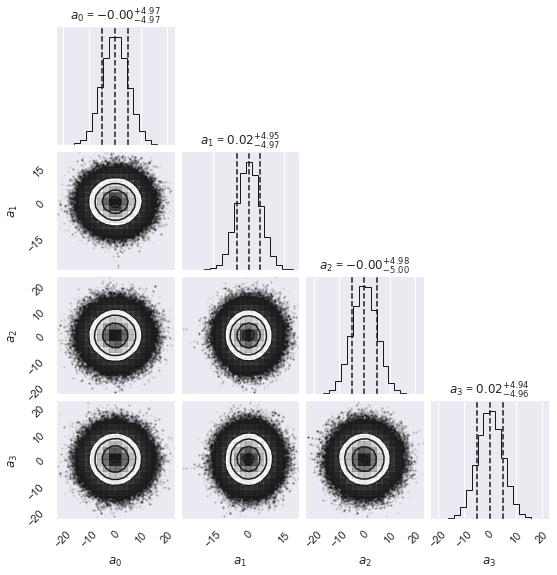

In [21]:
#reshape and cut burn-in
emcee_trace_pr = sampler_pr.chain[:, :, :].reshape(-1, ndim).T

#burn-in
nburnin = 1000

#throw out the burn-in and reshape again
emcee_trace_pr = sampler_pr.chain[:, nburnin:, :].reshape(-1, ndim).T
emcee_lnprob_pr = sampler_pr.lnprobability[:, nburnin:].reshape(-1).T

#print the coefficients from the maximum of the mode
max_mode_a_pr=max_of_mode(sampler_pr)
with np.printoptions(precision=3):
    print(f'Max prior is at: {max_mode_a_pr}')
    
#use the emcee_trace parameter and plot the samples
fig, ax = plt.subplots(ndim,ndim, figsize=(8,8))
corner.corner(emcee_trace_pr.T,labels=[r"$a_{0}$", r"$a_{1}$", r"$a_{2}$", r"$a_{3}$", r"$a_{4}$", r"$a_{5}$", r"$a_{6}$"], quantiles=[0.16, 0.5, 0.84],fig=fig,show_titles=True);

In [22]:
#make an array of the chain results for a3
pr_result = sampler_pr.chain[:,:,:]

#extract the a3 results
pr_result_a3 = sampler_pr.chain[:,:,k]

### Plotting the histograms

First, we set a bin range and width for both distributions so that we can directly compare numbers of samples in each bin. 

In [33]:
#bin ranges for BOTH of the distributions
bin_ranges = np.linspace(-25.0, 25.0, 80)

Now we introduce another function, called the __autocorrelation__: this will measure the amount of 'correlated'-ness of the samples. We'll take the correlation time out of the function and use it to determine what amount to thin our samples by, so we essentially weed out the dependent samples. 

In [35]:
def autocorrelation(chain, max_lag=100):
    dimension = len(chain)
    acors = np.empty(max_lag+1)
    if max_lag > len(chain)/5:
        warnings.warn('max_lag is more than one fifth the chain length')
    # Create a copy of the chain with average zero
    chain1d = chain - np.average(chain)
    for lag in range(max_lag+1):
        unshifted = None
        shifted = chain1d[lag:]
        if 0 == lag:
            unshifted = chain1d
        else:
            unshifted = chain1d[:-lag]
        normalization = np.sqrt(np.dot(unshifted, unshifted))
        normalization *= np.sqrt(np.dot(shifted, shifted))
        acors[lag] = np.dot(unshifted, shifted) / normalization
    return acors

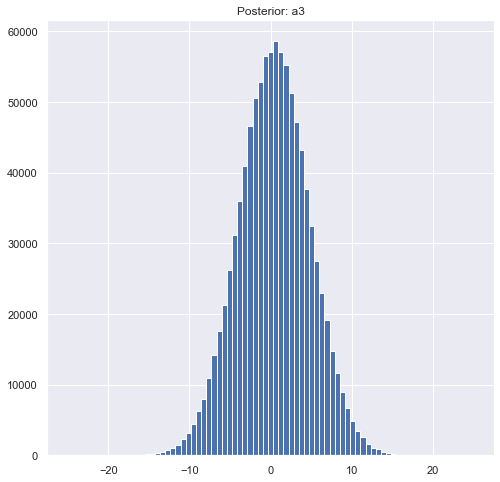

Output:  [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 0.0000e+00 3.0000e+00 3.0000e+00 1.8000e+01
 3.2000e+01 2.4000e+01 6.4000e+01 1.3900e+02 1.9200e+02 3.0600e+02
 4.3500e+02 7.4800e+02 1.0440e+03 1.4810e+03 2.3500e+03 3.1680e+03
 4.4480e+03 6.2690e+03 8.0080e+03 1.0943e+04 1.4119e+04 1.7554e+04
 2.1289e+04 2.6215e+04 3.1158e+04 3.5951e+04 4.0961e+04 4.6605e+04
 5.0552e+04 5.2749e+04 5.6517e+04 5.7090e+04 5.8592e+04 5.7044e+04
 5.5192e+04 5.1222e+04 4.7081e+04 4.3259e+04 3.7724e+04 3.2419e+04
 2.7446e+04 2.2957e+04 1.9101e+04 1.4823e+04 1.1577e+04 9.0110e+03
 6.6510e+03 4.8450e+03 3.3860e+03 2.5680e+03 1.5770e+03 1.0900e+03
 8.7900e+02 4.4600e+02 2.5500e+02 1.5000e+02 9.8000e+01 5.6000e+01
 5.1000e+01 1.7000e+01 1.1000e+01 8.0000e+00 1.6000e+01 3.0000e+00
 7.0000e+00 2.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00]
The autocorrelation information is: p = [ 24.5426829  -26.10293783]; cov = [[ 0.00010799 -0.00013465]
 [-0.

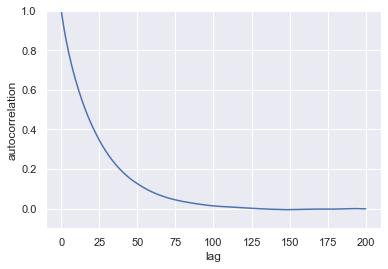

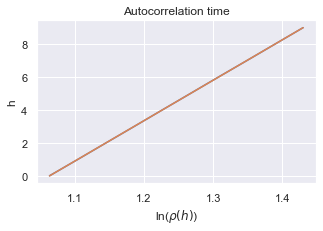

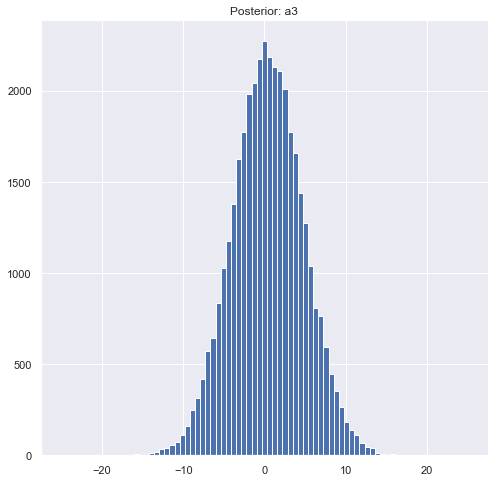

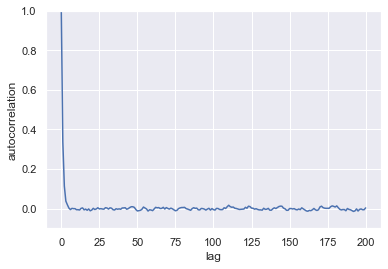

In [37]:
#test a3 by implementing SDDR via a histogram sample counting method
fig, ax = plt.subplots(1,1, figsize=(8,8))

#flatten into a 1d array
post_data = post_result_a3.flatten()

#plot the histogram
post_npoints, post_rbins, post_patches = ax.hist(post_data, bins = bin_ranges)
ax.set_title('Posterior: a3')
plt.show()

print('Output: ', post_npoints)

#plot the autocorrelation
post_acors = autocorrelation(post_data, max_lag=200)
fig, ax = plt.subplots()
ax.plot(post_acors);
ax.set(xlabel='lag', ylabel='autocorrelation', ylim=(-.1, 1));

#determine the autocorrelation time
post_rho = post_acors[25:35]

fig = plt.figure(figsize=(5,3))
post_y = np.arange(10)
post_x = -np.log(post_rho)
        
plt.xlabel(r'ln($\rho(h)$)')
plt.ylabel('h')
plt.title('Autocorrelation time')
plt.plot(post_x, post_y)

#linear fit
p, cov = np.polyfit(post_x, post_y, 1, cov = True)
print('The autocorrelation information is: p = {}; cov = {}'.format(p, cov))
plt.plot(post_x, p[0]*post_x + p[1])

#adjust the samples by thinning according to the autocorrelation time
post_data_thin = []
print(len(post_data))
for i in range(len(post_data)):
    if i % 26 == 0:
        post_data_thin.append(post_data[i])

#array thinned samples
post_data_thin = np.array(post_data_thin)
print(len(post_data_thin))

#re-draw the histogram with thinned samples
fig, ax1 = plt.subplots(1,1, figsize=(8,8))    
post_npoints_thin, post_rbins_thin, post_patches_thin = ax1.hist(post_data_thin, bins = bin_ranges)
ax1.set_title('Posterior: a3')
plt.show()

#re-draw the autocorrelation function
post_thin_acors = autocorrelation(post_data_thin, max_lag=200)
fig, ax2 = plt.subplots()
ax2.plot(post_thin_acors);
ax2.set(xlabel='lag', ylabel='autocorrelation', ylim=(-.1, 1));

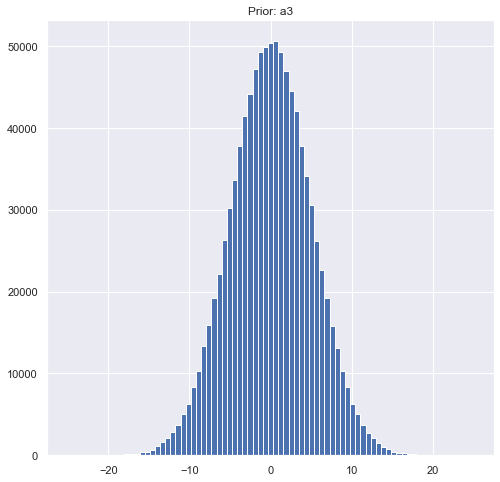

Output:  [0.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 4.0000e+00 2.0000e+00
 3.0000e+00 1.3000e+01 2.4000e+01 4.0000e+01 6.1000e+01 1.1200e+02
 1.6200e+02 2.1200e+02 3.6400e+02 4.5400e+02 6.7800e+02 1.0910e+03
 1.5880e+03 2.0730e+03 2.7960e+03 3.7120e+03 5.0300e+03 6.3020e+03
 8.2990e+03 1.0325e+04 1.3381e+04 1.5866e+04 1.9159e+04 2.2196e+04
 2.6265e+04 3.0247e+04 3.3666e+04 3.7746e+04 4.1419e+04 4.4082e+04
 4.7198e+04 4.9267e+04 4.9905e+04 5.0387e+04 5.0579e+04 4.9218e+04
 4.6939e+04 4.4494e+04 4.2007e+04 3.7831e+04 3.4086e+04 3.0596e+04
 2.6230e+04 2.2582e+04 1.9243e+04 1.5790e+04 1.3088e+04 1.0234e+04
 8.3840e+03 6.2740e+03 5.0300e+03 3.7150e+03 2.7260e+03 2.0720e+03
 1.4740e+03 1.0620e+03 7.7100e+02 4.4000e+02 3.3500e+02 2.5100e+02
 1.5600e+02 1.3400e+02 6.0000e+01 3.4000e+01 1.8000e+01 4.0000e+00
 9.0000e+00 2.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00]
The autocorrelation information is: p = [ 25.22085072 -26.50273666]; cov = [[ 0.00012869 -0.00015819]
 [-0.

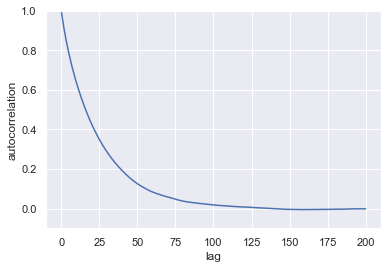

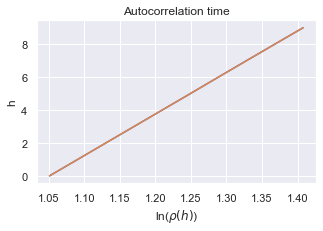

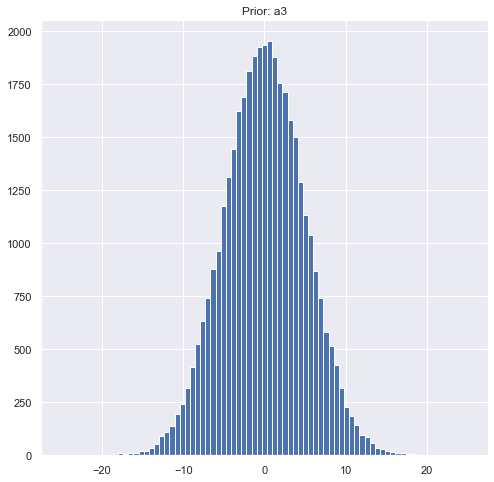

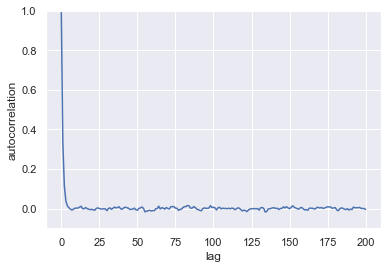

In [36]:
#test a3 by implementing SDDR via a histogram sample counting method
fig, ax = plt.subplots(1,1, figsize=(8,8))

#flatten into a 1d array
pr_data = pr_result_a3.flatten()

#plot the histogram
pr_npoints, pr_rbins, pr_patches = ax.hist(pr_data, bins = bin_ranges)
ax.set_title('Prior: a3')
plt.show()

print('Output: ', pr_npoints)

#plot the autocorrelation
pr_acors = autocorrelation(pr_data, max_lag=200)
fig, ax = plt.subplots()
ax.plot(pr_acors);
ax.set(xlabel='lag', ylabel='autocorrelation', ylim=(-.1, 1));

#determine the autocorrelation time
pr_rho = pr_acors[25:35]

fig = plt.figure(figsize=(5,3))
pr_y = np.arange(10)
pr_x = -np.log(pr_rho)
        
plt.xlabel(r'ln($\rho(h)$)')
plt.ylabel('h')
plt.title('Autocorrelation time')
plt.plot(pr_x, pr_y)

#linear fit
p, cov = np.polyfit(pr_x, pr_y, 1, cov = True)
print('The autocorrelation information is: p = {}; cov = {}'.format(p, cov))
print('The autocorrelation time is: {}'.format())
plt.plot(pr_x, p[0]*pr_x + p[1])

#adjust the samples by thinning according to the autocorrelation time
pr_data_thin = []
print(len(pr_data))
for i in range(len(pr_data)):
    if i % 26 == 0:
        pr_data_thin.append(pr_data[i])

#array thinned samples
pr_data_thin = np.array(pr_data_thin)

#re-draw the histogram with thinned samples
fig, ax1 = plt.subplots(1,1, figsize=(8,8))    
pr_npoints_thin, pr_rbins_thin, pr_patches_thin = ax1.hist(pr_data_thin, bins = bin_ranges)
ax1.set_title('Prior: a3')
plt.show()

#re-draw the autocorrelation function
pr_thin_acors = autocorrelation(pr_data_thin, max_lag=200)
fig, ax2 = plt.subplots()
ax2.plot(pr_thin_acors);
ax2.set(xlabel='lag', ylabel='autocorrelation', ylim=(-.1, 1));

The above plots show the histograms of the samples of the prior and the posterior, and the autocorrelation functions. Notice how, before we thinned the samples, the histogram was much larger in scale (higher number of samples in each bin) and the autocorrelation function sloped much more gradually. Cutting the dependent samples out leads to a function that drops off almost immediately, making the 'lag' close to 0. This is what we want, since cutting the lag to zero means our system is counting only equilibrated samples. Cutting this to zero isn't really occurring here, but we are close enough that we can accept this improvement and move on to the SDDR itself. 

To calculate the SDDR, we will only use the central bin of the thinned prior and posterior. We first find the index of this bin, and then count the number of samples in it, and calculate the $\sqrt{N}$ variance of these samples.

In [38]:
#index of central bin
index = int(len(bin_ranges)/2 - 1)
print('Index of bin edge: {}'.format(index))
print(bin_ranges)

#extract number of samples in the bin in the posterior and prior
post_samples = post_npoints[index]
pr_samples = pr_npoints[index]
print('\nNumber of posterior samples: {}'.format(post_samples))
print('\nNumber of prior samples: {}'.format(pr_samples))

#extract number of samples in the bin in the posterior and prior (thinned)
post_samples_thin = post_npoints_thin[index]
pr_samples_thin = pr_npoints_thin[index]
print('\nNumber of thinned posterior samples: {}'.format(post_samples_thin))
print('\nNumber of thinned prior samples: {}'.format(pr_samples_thin))

#statistical error of distributions
error_pr = np.sqrt(pr_samples)
error_post = np.sqrt(post_samples)

#statistical error of distributions (thinned)
error_pr_thin = np.sqrt(pr_samples_thin)
error_post_thin = np.sqrt(post_samples_thin)

#print the errors out
print('\nStatistical error on the posterior samples: ', error_post)
print('\nStatistical error on the prior samples: ', error_pr)

#print the errors out (thinned)
print('\nStatistical error on the thinned posterior samples: ', error_post_thin)
print('\nStatistical error on the thinned prior samples: ', error_pr_thin)

Index of bin edge: 39
[-25.         -24.36708861 -23.73417722 -23.10126582 -22.46835443
 -21.83544304 -21.20253165 -20.56962025 -19.93670886 -19.30379747
 -18.67088608 -18.03797468 -17.40506329 -16.7721519  -16.13924051
 -15.50632911 -14.87341772 -14.24050633 -13.60759494 -12.97468354
 -12.34177215 -11.70886076 -11.07594937 -10.44303797  -9.81012658
  -9.17721519  -8.5443038   -7.91139241  -7.27848101  -6.64556962
  -6.01265823  -5.37974684  -4.74683544  -4.11392405  -3.48101266
  -2.84810127  -2.21518987  -1.58227848  -0.94936709  -0.3164557
   0.3164557    0.94936709   1.58227848   2.21518987   2.84810127
   3.48101266   4.11392405   4.74683544   5.37974684   6.01265823
   6.64556962   7.27848101   7.91139241   8.5443038    9.17721519
   9.81012658  10.44303797  11.07594937  11.70886076  12.34177215
  12.97468354  13.60759494  14.24050633  14.87341772  15.50632911
  16.13924051  16.7721519   17.40506329  18.03797468  18.67088608
  19.30379747  19.93670886  20.56962025  21.20253165  2

Now we get to the actual SDDR, which merely involves dividing the number of samples in the central bin of the posterior by the number of samples in the central bin of the prior.

In [39]:
#divide to get the SDDR
sddr = post_samples / pr_samples

#sddr, thinned 
sddr_thin = post_samples_thin / pr_samples_thin

#print the SDDR results
print('The SDDR for a{} is: {}'.format(k, sddr))
print('\nThe thinned SDDR for a{} is: {}'.format(k, sddr_thin))

#statistical error propagation
error_prop = sddr * np.sqrt((error_post/post_samples)**2 + (error_pr/pr_samples)**2)
error_prop_thin = sddr_thin * np.sqrt((error_post_thin/post_samples_thin)**2 + (error_pr_thin/pr_samples_thin)**2)

#print the error propagation result
print('\nThe statistical error is: {}'.format(error_prop))
print('\nThe thinned statistical error is: {}'.format(error_prop_thin))

The SDDR for a3 is: 1.1330303451287038

The thinned SDDR for a3 is: 1.171826625386997

The statistical error is: 0.006925641977620171

The thinned statistical error is: 0.036238262861629025


If we do this for each polynomial degree against its neighbour, we will get an average SDDR and standard deviation for each of those 'ladder-rungs' of models. A table of this is included below. Due to the fluctuation of the SDDR given our randomized starting position each time we run this routine, we have run each ladder-rung 10 times and averaged the SDDR from those.

The results from our averaged runs for each comparison of polynomial degrees are below. 

| Comparison | SDDR mean result | Standard deviation |
| :-: | :-: | :-: |
| $a_{1}$ to $a_{2}$ | 0.198692 | 0.009607 |
| $a_{2}$ to $a_{3}$ | 1.153625 | 0.035598 |
| $a_{3}$ to $a_{4}$ | 1.030905 | 0.024053 |
| $a_{4}$ to $a_{5}$ | 1.006302 | 0.024444 |

From this table, we can see that $a_{2}$ compared to $a_{3}$ gives the largest difference between two polynomial degree models that we have studied here, which implies that $a_{2}$ is the best choice for the Schindler-Phillips data set. A large density ratio, >> 1.0, tells us that the model with one less free parameter is favoured, so this shows that $a_{2}$ would be the better choice. This is further supported by the two methods we looked at previously, where the evidence was most strongly favouring a degree of 2. 

## Summary 